In [1]:
import os
import random
from datetime import datetime

path = "./Dataset/data"
labelPath = "Dataset/labels"

data = os.listdir(path)
datasetLen = len(data)

# random shuffle data
# random.shuffle(data)

In [2]:
import SimpleITK as sitk
import numpy as np
from utils import *
import os

timeStep = 0.04
numberOfIterations = 10

# Set the number of threads
# sitk.ImageRegistrationMethod().SetGlobalDefaultNumberOfThreads(1)

pathName = os.path.join(path, data[0])
originalImage = sitk.ReadImage(pathName)
originalLabel = sitk.ReadImage(os.path.join(labelPath, data[0]))

curvatureImage = sitk.CurvatureFlow(originalImage, 
                                timeStep = timeStep, 
                                numberOfIterations = numberOfIterations)

pathName = os.path.join(path, data[2])
'''
originalMovingImage = sitk.ReadImage(pathName)
MovingImage = sitk.HistogramMatching(sitk.CurvatureFlow(originalMovingImage,
                                                  timeStep = timeStep, 
                                                  numberOfIterations = numberOfIterations),
                               curvatureImage)
'''
originalMovingImage = sitk.CurvatureFlow(sitk.ReadImage(pathName),
                                                  timeStep = timeStep, 
                                                  numberOfIterations = numberOfIterations)
MovingImage = sitk.HistogramMatching(originalMovingImage, curvatureImage)


In [3]:
from PIL import Image
import numpy as np

def showImg_(img, z=60):
    a = sitk.GetArrayFromImage(img[z,:,:])
    disImg = Image.fromarray(np.interp(a, (a.min(), a.max()), (0, 255)).astype('uint8'))
    disImg.show()
    
def showImg2_(img, z=60):
    disImg = Image.fromarray(sitk.GetArrayFromImage(img[z,:,:]).astype('uint8'))
    disImg.show()
    
def showImg3_(img, z=60):
    a = sitk.GetArrayFromImage(img[z,:,:])
    disImg = image.fromarray(np.interp(a, (0, 5000), (0, 255)).astype('uint8'))
    disImg.show()
    
def showImg4_(img, z=60):
    img2 = Image.fromarray(sitk.GetArrayFromImage(img[z,:,:])*60, 'L')
    img2.show()
    
def showImg5_(img):
    a = sitk.GetArrayFromImage(img)
    disImg = Image.fromarray(np.interp(a, (a.min(), a.max()), (0, 255)).astype('uint8'))
    disImg.show()
    return disImg

def createOverlays(image1, image2):
    whiteImage = sitk.GetImageFromArray(255*np.ones(image1.GetSize()[::-1]))
    whiteImage.CopyInformation(image1)
    image1.CopyInformation(whiteImage)
    temp = sitk.LabelOverlay(whiteImage, image1, opacity=0.1)
    whiteImage2 = sitk.GetImageFromArray(255*np.ones(image2.GetSize()[::-1]))
    whiteImage2.CopyInformation(image2)
    temp2 = sitk.LabelOverlay(whiteImage2, image2, opacity=0.1, colormap=(0,0,0,1,0,0,0,1))

    overlay1 = Image.fromarray(sitk.GetArrayFromImage(temp).astype('uint8'), 'RGB')
    overlay2 = Image.fromarray(sitk.GetArrayFromImage(temp2).astype('uint8'), 'RGB')
    overlay11 = overlay1.convert("RGBA")
    overlay22 = overlay2.convert("RGBA")

    new_img = Image.blend(overlay11, overlay22, 0.5)
    
    return (sitk.GetImageFromArray(overlay11), sitk.GetImageFromArray(overlay22), sitk.GetImageFromArray(new_img))

In [ ]:
z = 60
showImg5_(originalImage[z,:,:]).save('thesis/images/original_1.png')
showImg5_(curvatureImage[z,:,:]).save('thesis/images/curvature_1.png')

z = 100
showImg5_(originalImage[z,150:300,50:200]).save('thesis/images/original_1_1.png')
showImg5_(curvatureImage[z,150:300,50:200]).save('thesis/images/curvature_1_1.png')

z = 250
showImg5_(originalImage[:,z,:]).save('thesis/images/original_2.png')
showImg5_(curvatureImage[:,z,:]).save('thesis/images/curvature_2.png')

z = 250
showImg5_(originalImage[:,:,z]).save('thesis/images/original_3.png')
showImg5_(curvatureImage[:,:,z]).save('thesis/images/curvature_3.png')

In [ ]:
import matplotlib.pyplot as plt

# plt.style.use('seaborn-deep')

histogramFig, ax1 = plt.subplots(dpi=300)

plt.hist(sitk.GetArrayFromImage(curvatureImage).reshape((-1,)), bins='auto', alpha=0.7, label='Fixed Image')
_, bins, _ = plt.hist(sitk.GetArrayFromImage(MovingImage).reshape((-1,)), bins='auto', alpha=0.7, label='Moving image after histogram matching')
# plt.hist(sitk.GetArrayFromImage(originalMovingImage).reshape((-1,)), bins=bins, alpha=0.7, label='Original Moving image')
plt.hist(sitk.GetArrayFromImage(originalMovingImage).reshape((-1,)), bins='auto', alpha=0.7, label='Original Moving image')

ax1.set_xlim([-1,200])

plt.legend(loc='best')
plt.title("Histograms")
plt.xlabel("Image intensity")
plt.ylabel("Frequency")

plt.show()

histogramFig.savefig('thesis/images/histogram_plot.png')

In [ ]:
z = 60
# showImg5_(curvatureImage[z,:,:]).save('thesis/images/curvature_1.png') # we got this
z = 50
showImg5_(originalMovingImage[z,:,:]).save('thesis/images/original_moving_1.png')
showImg5_(MovingImage[z,:,:]).save('thesis/images/original_moving_histogram_matching_1.png')


In [4]:
pathName = os.path.join(path, data[1])
'''
originalMovingImage = sitk.ReadImage(pathName)
MovingImage = sitk.HistogramMatching(sitk.CurvatureFlow(originalMovingImage,
                                                  timeStep = timeStep, 
                                                  numberOfIterations = numberOfIterations),
                               curvatureImage)
'''
originalMovingImage = sitk.CurvatureFlow(sitk.ReadImage(pathName),
                                                  timeStep = timeStep, 
                                                  numberOfIterations = numberOfIterations)
MovingImage = sitk.HistogramMatching(originalMovingImage, curvatureImage)

label = sitk.ReadImage(os.path.join(labelPath, data[1]))

t = registrationElastixMask(curvatureImage, MovingImage, label)
registeredImage = resampleImage(MovingImage,  curvatureImage, t)
registeredLabel = resampleLabels(label, curvatureImage, t)

In [14]:
z = 60
image1, image2, image3 = createOverlays(originalLabel[z,:,:], registeredLabel[z,:,:])
showImg5_(image1).save('thesis/images/original_label_registration_1.png')
showImg5_(image2).save('thesis/images/moving_label_after_registration_1.png')
showImg5_(image3).save('thesis/images/combination_label_after_registration_1.png')
_, image2, image3 = createOverlays(originalLabel[z,:,:], label[z,:,:])
showImg5_(image2).save('thesis/images/moving_label_before_registration_1.png')
showImg5_(image3).save('thesis/images/combination_label_before_registration_1.png')

z = 250
image1, image2, image3 = createOverlays(originalLabel[:,z,:], registeredLabel[:,z,:])
showImg5_(image1[:,:,10:-120]).save('thesis/images/original_label_registration_2.png')
showImg5_(image2[:,:,10:-120]).save('thesis/images/moving_label_after_registration_2.png')
showImg5_(image3[:,:,10:-120]).save('thesis/images/combination_label_after_registration_2.png')
_, image2, image3 = createOverlays(originalLabel[:,z,:], label[:,z,:])
showImg5_(image2[:,:,10:-120]).save('thesis/images/moving_label_before_registration_2.png')
showImg5_(image3[:,:,10:-120]).save('thesis/images/combination_label_before_registration_2.png')

z = 250
image1, image2, image3 = createOverlays(originalLabel[:,:,z], registeredLabel[:,:,z])
showImg5_(image1[:,:,80:-80]).save('thesis/images/original_label_registration_3.png')
showImg5_(image2[:,:,80:-80]).save('thesis/images/moving_label_after_registration_3.png')
showImg5_(image3[:,:,80:-80]).save('thesis/images/combination_label_after_registration_3.png')
_, image2, image3 = createOverlays(originalLabel[:,:,z], label[:,:,z])
showImg5_(image2[:,:,80:-80]).save('thesis/images/moving_label_before_registration_3.png')
showImg5_(image3[:,:,80:-80]).save('thesis/images/combination_label_before_registration_3.png')

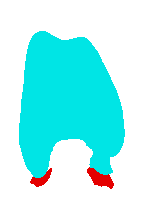

In [11]:
showImg5_(image2[:,:,80:-80])

In [8]:
image2.GetSize()

(4, 160, 384)

In [ ]:
z = 60
showImg5_(registeredImage[z,:,:])
showImg5_(curvatureImage[z,:,:])
showImg_(registeredLabel, z)
showImg_(originalLabel, z)

In [ ]:
# showImg5_(sitk.LabelOverlay(curvatureImage, originalLabel, opacity=0.1)[z,:,:])
# TODO: fix this, doesn't work
z = 60
# temp = sitk.LabelOverlay(curvatureImage, originalLabel, opacity=0.1)[z,:,:]
whiteImage = sitk.GetImageFromArray(255*np.ones(curvatureImage.GetSize()[::-1]))
whiteImage.CopyInformation(curvatureImage)
temp = sitk.LabelOverlay(whiteImage, originalLabel, opacity=0.1)[z,:,:]
whiteImage2 = sitk.GetImageFromArray(255*np.ones(registeredImage.GetSize()[::-1]))
whiteImage2.CopyInformation(registeredImage)
temp2 = sitk.LabelOverlay(whiteImage2, registeredLabel, opacity=0.1, colormap=(0,0,0,1,0,0,0,1))[z,:,:]

overlay1 = Image.fromarray(sitk.GetArrayFromImage(temp).astype('uint8'), 'RGB')
overlay2 = Image.fromarray(sitk.GetArrayFromImage(temp2).astype('uint8'), 'RGB')
overlay11 = overlay1.convert("RGBA")
overlay22 = overlay2.convert("RGBA")

new_img = Image.blend(overlay11, overlay22, 0.5)
# showImg5_(sitk.GetImageFromArray(new_img)[z,:,:])
showImg5_(sitk.GetImageFromArray(overlay11))
showImg5_(sitk.GetImageFromArray(overlay22))
showImg5_(sitk.GetImageFromArray(new_img))


In [ ]:
z = 60
image1, image2, image3 = createOverlays(originalLabel[z,:,:], registeredLabel[z,:,:])

showImg5_(image1)
showImg5_(image2)
showImg5_(image3)

In [ ]:
# image1, image2, image3 = createOverlays(originalLabel[z,:,:], registeredLabel[z,:,:])


In [ ]:
# overlay1 = Image.fromarray(sitk.GetArrayFromImage(temp))
a = sitk.GetArrayFromImage(temp).astype('uint8')
print(a.dtype)
type(Image.fromarray(a))

In [ ]:
sitk.GetArrayFromImage(curvatureImage).reshape((-1,)).shape

In [ ]:
np.max(sitk.GetArrayFromImage(originalMovingImage).reshape((-1,)))

In [ ]:
a = sitk.LabelOverlayImageFilter()
a.GetColormap()